In [1]:
#@title ## INSTALL/IMPORT PACKAGES
!pip install -q flask-ngrok
!pip install -q xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelBinarizer, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from flask import Flask
from flask import request
from requests import get

import xgboost

You should consider upgrading via the '/home/amukhsimov/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/amukhsimov/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


# LOAD/ANALYZE DATA

Read dataset from disk:

In [2]:
df = pd.read_csv('bodyPerformanceI.csv')

Here how the data looks like:

In [3]:
df

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,24.0,F,152.4,42.5,23.4,57.0,112.0,27.4,14.2,50.0,184.0,C
1,27.0,F,162.1,70.9,35.7,97.0,148.0,30.6,11.0,42.0,157.0,D
2,23.0,M,173.7,68.3,13.6,76.0,137.0,47.7,16.5,48.0,208.0,C
3,31.0,M,168.2,70.5,15.5,82.0,145.0,39.6,19.9,66.0,264.0,C
4,25.0,M,175.1,64.8,6.9,65.0,118.0,42.0,19.8,49.0,252.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...
7010,21.0,M,179.6,78.6,16.3,64.0,118.0,54.1,25.9,58.0,248.0,B
7011,56.0,M,166.8,64.0,21.4,75.0,132.0,50.7,13.0,36.0,197.0,B
7012,26.0,M,177.4,78.3,14.0,74.0,115.0,53.3,15.3,63.0,234.0,A
7013,49.0,M,177.2,83.0,19.7,98.0,158.0,40.2,14.9,50.0,203.0,C


In [4]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000,7015.000000
mean,36.801283,168.751732,67.046887,22.642606,78.648952,130.364490,37.289624,15.790925,40.614597,191.824391
std,13.649180,8.256259,11.242355,6.796773,10.675237,14.538937,10.443406,6.973073,13.075697,38.528746
min,21.000000,125.000000,34.400000,3.500000,6.000000,43.900000,0.000000,-20.000000,0.000000,0.000000
25%,25.000000,162.900000,58.500000,17.800000,71.000000,120.000000,27.800000,11.800000,32.000000,163.000000
50%,32.000000,169.400000,67.400000,22.200000,79.000000,130.000000,38.700000,16.000000,42.000000,195.000000
75%,48.000000,174.700000,74.700000,27.100000,86.000000,141.000000,45.200000,20.000000,50.000000,222.000000
max,64.000000,193.800000,125.700000,54.900000,156.200000,193.000000,69.900000,213.000000,78.000000,295.000000


We see that men are twice more than women:

In [5]:
df['gender'].value_counts()

M    4552
F    2463
Name: gender, dtype: int64

In [6]:
# give columns shorter names, so it would be more comfortable to plot ones
df_base = df.copy()
columns = ['age', 'gender', 'height', 'weight', 'body_fat', 'diastolic',
           'systolic', 'grip', 'sit_bend', 'sit_ups', 'broad_jump', 'class']
df.columns = columns

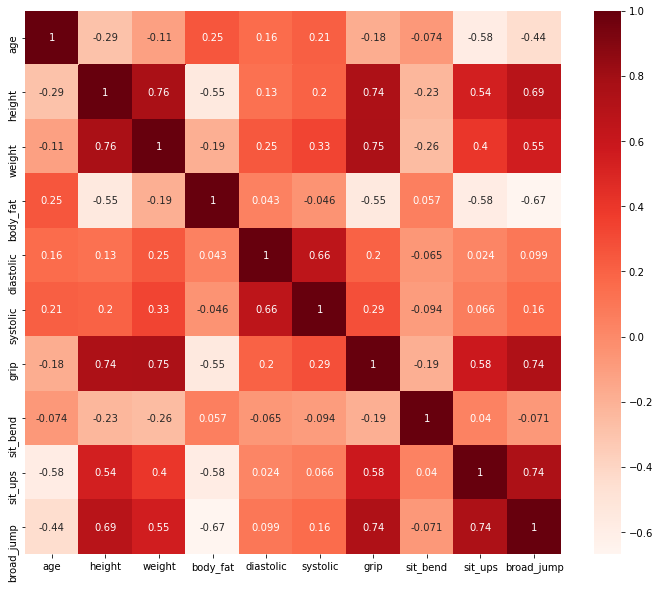

In [7]:
#@title ## PLOT CORRELATION MATRIX USING HEATMAP
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

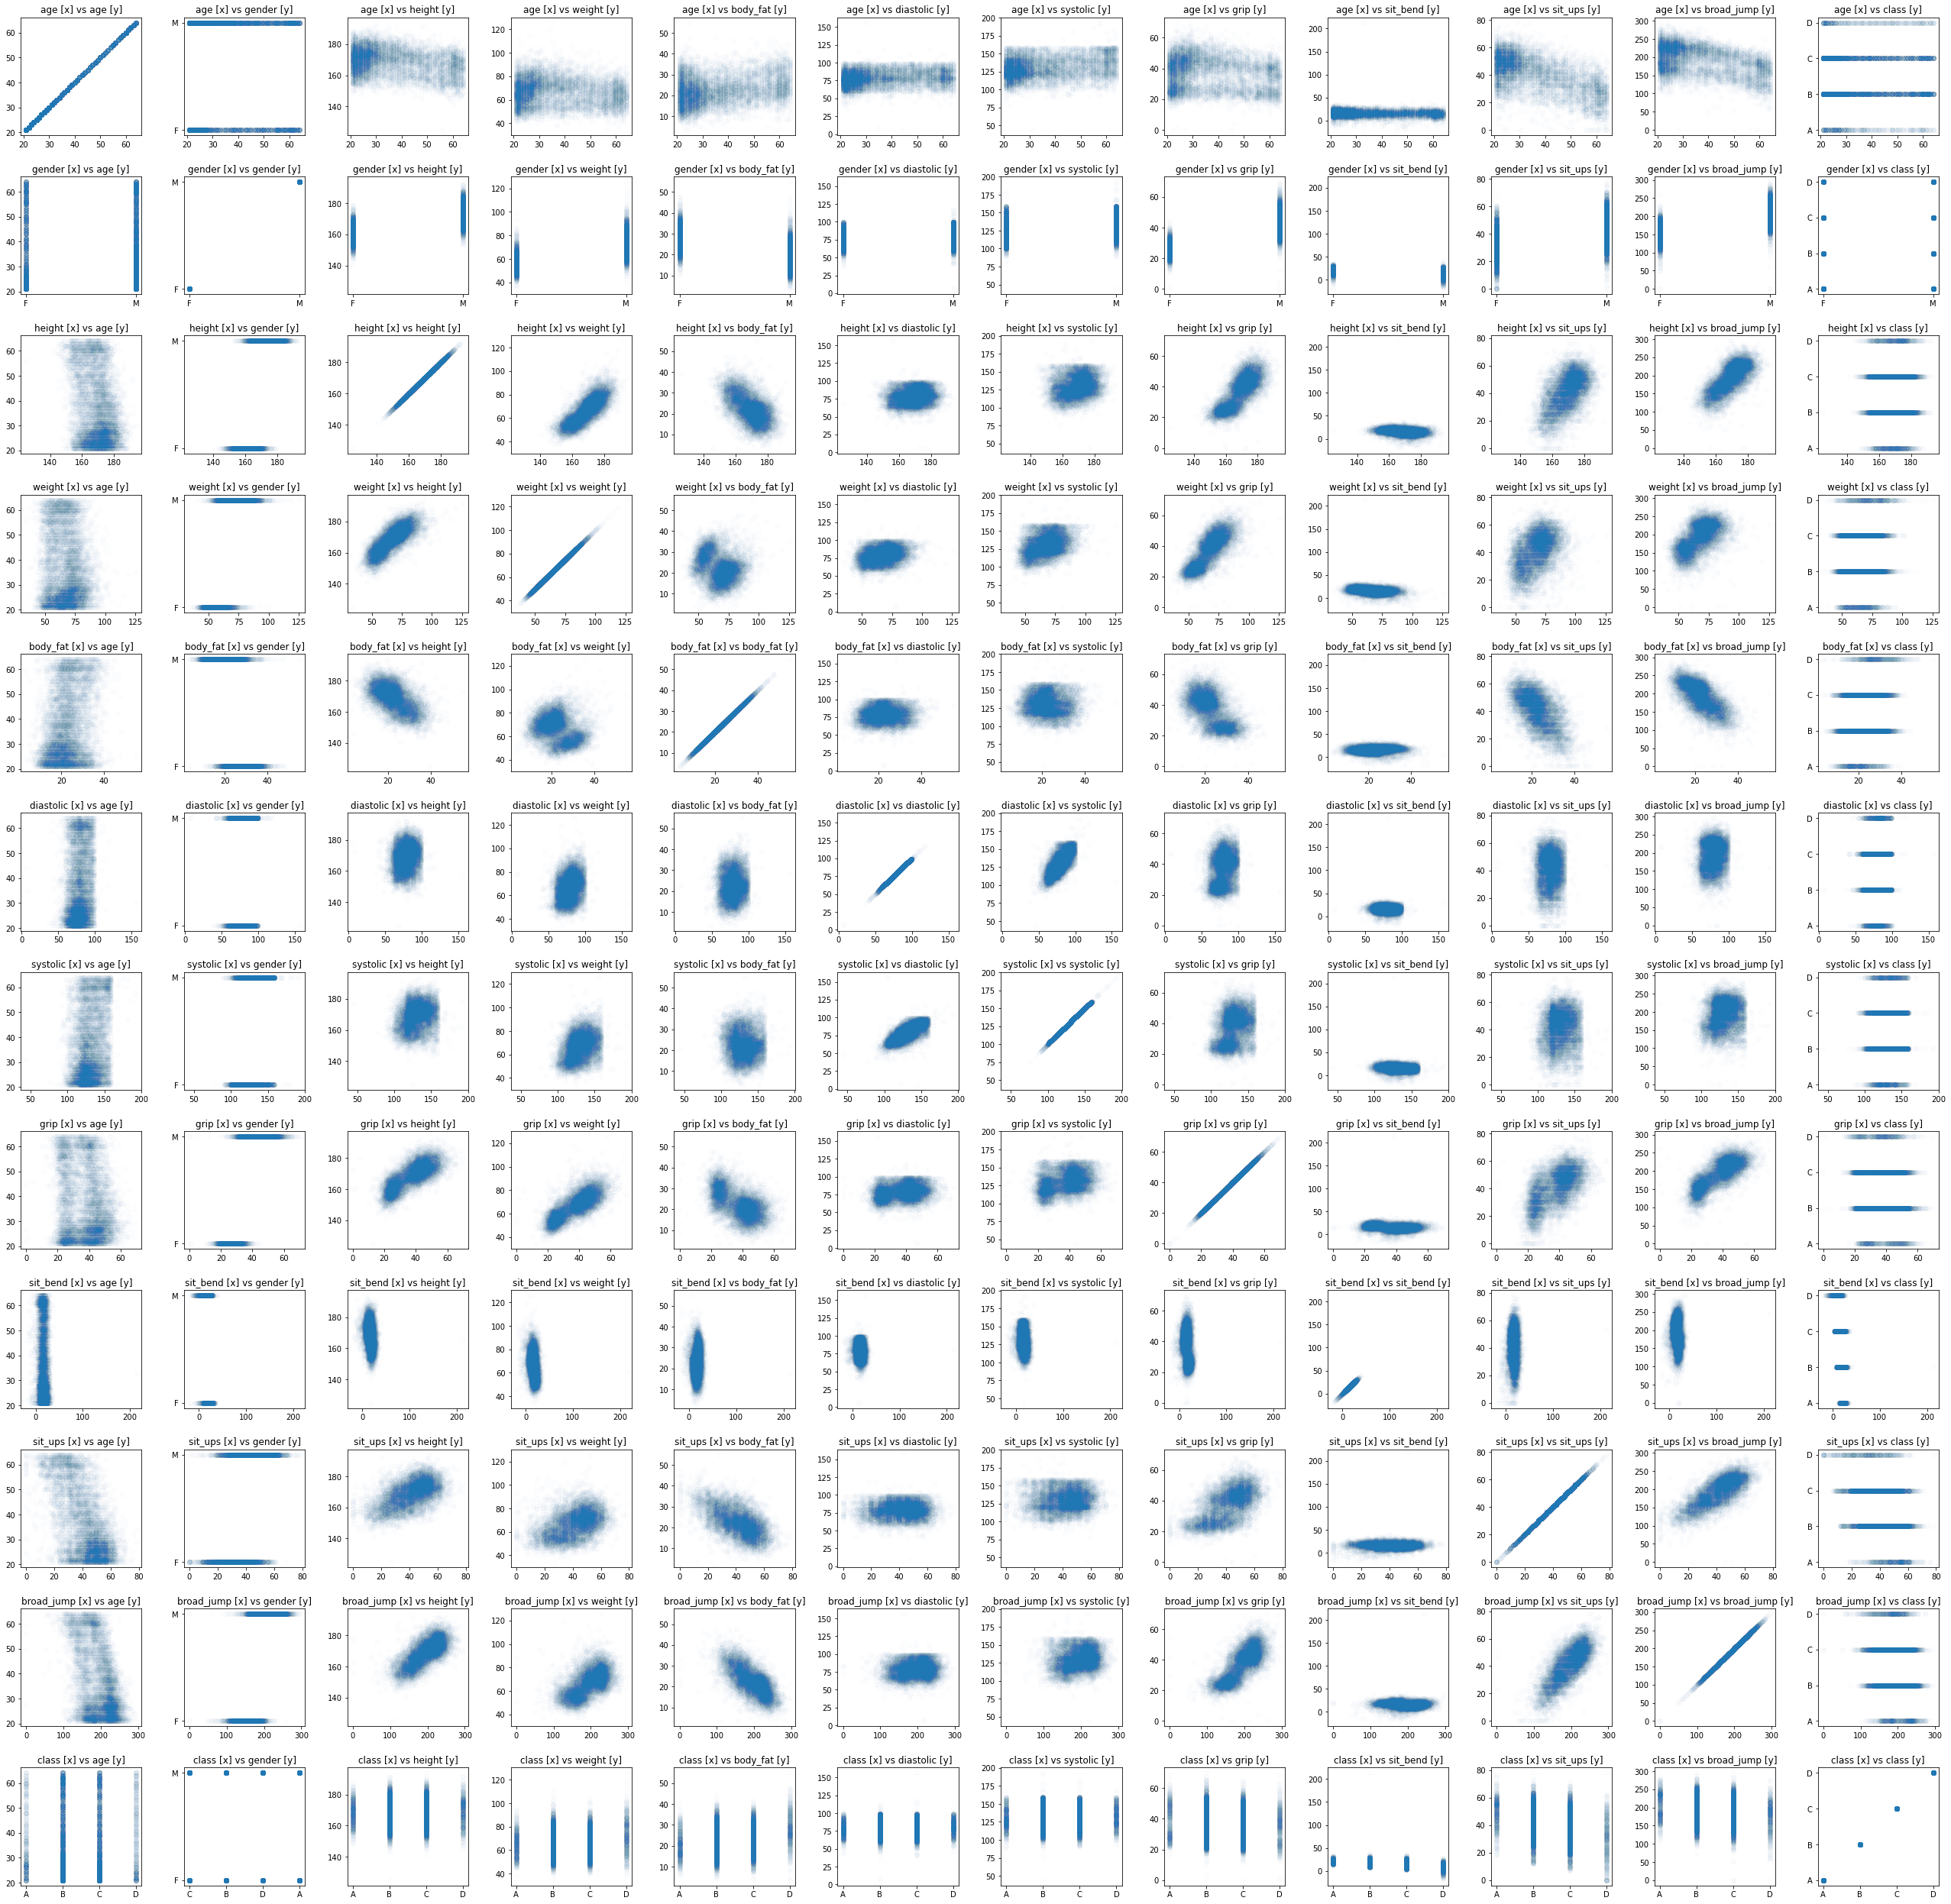

In [8]:
#@title ## SCATTER PLOT ALL FEATURES RELATIONS
fig = plt.figure(figsize=(45, 45))
gs = fig.add_gridspec(len(columns), len(columns), wspace=0.35, hspace=0.35)

for i, attr1 in enumerate(columns):
    for j, attr2 in enumerate(columns):
        id = i * len(columns) + j
        ax = fig.add_subplot(gs[i, j])

        df_arg1, df_arg2 = df[attr1].values, df[attr2].values
        argsort = df_arg1.argsort()
        if attr2 in ('gender', 'class'):
            argsort = df_arg2.argsort()
        df_arg1, df_arg2 = df_arg1[argsort], df_arg2[argsort]
        # if attribute is discrete
        if attr1 in ('gender', 'class') or attr2 in ('gender', 'class'):
            alpha = 2e-4
        else:
            alpha = 0.015

        ax.scatter(df_arg1, df_arg2, alpha=0.01)
        ax.set_title(f'{attr1} [x] vs {attr2} [y]')

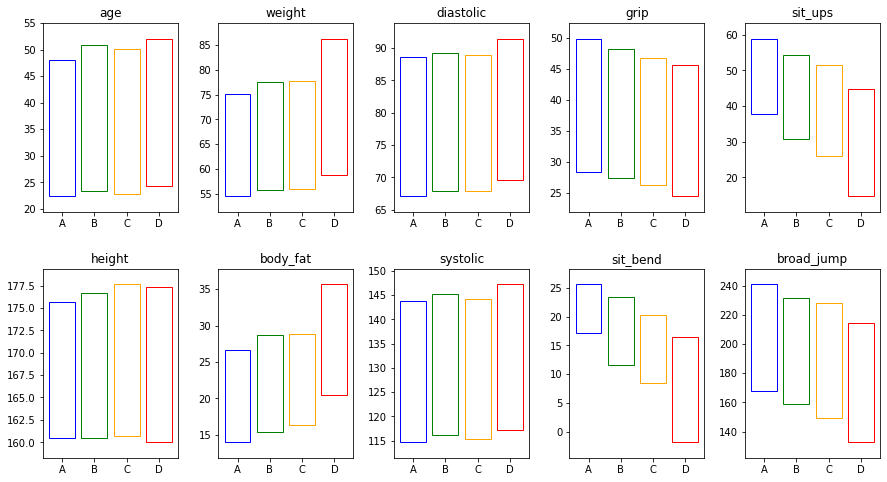

In [10]:
#@title ## BOX PLOT OF FEATURES VS CLASS
df_std = df.groupby('class').std().reset_index()
df_mean = df.groupby('class').mean().reset_index()

attributes = [
  'age',
  'height',
  'weight',
  'body_fat',
  'diastolic',
  'systolic',
  'grip',
  'sit_bend',
  'sit_ups',
  'broad_jump',
]

fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 5, wspace=0.3, hspace=0.3)

for i, attribute_name in enumerate(attributes):
    ax = fig.add_subplot(gs[i % 2, i // 2])
    std = df_std[attribute_name]
    mean = df_mean[attribute_name]

    ax.bar(['A','B','C','D'], 
            std * 2, 
            bottom=mean - std, 
            fill=False, 
            edgecolor=['blue', 'green', 'orange', 'red'],
            linewidth=1,)
    ax.set_title(attribute_name)
    ymin, ymax = (mean - std).min(), (mean + std).max()
    ax.set_ylim(bottom=ymin - (ymax - ymin) / 10, top=ymax + (ymax - ymin) / 10)

***From the plot above we see that the most correlated feature is "sit and bend forward_cm"***

# PREPROCESS DATA

## TRANSFORM/SPLIT/SAMPLE

In [11]:
class BodyPerformanceTransformer:
    def __init__(self):
        self.gender_binarizer = LabelBinarizer()
        self.class_binarizer = LabelBinarizer()
        self.scaler = RobustScaler()
        self.imputer = SimpleImputer(strategy='mean')

    def fit(self, X, y):
        """
        X: numpy array of [age	gender, height_cm, weight_kg, body fat_%, 
                           diastolic, systolic, gripForce, 
                           sit and bend forward_cm, sit-ups counts, 
                           broad jump_cm], 2d array
        y: numpy array of classes, 1d array
        """
        gender = X[:, 1]
        scalable_features = np.c_[X[:, :1], X[:, 2:]]

        self.gender_binarizer.fit(gender)
        scalable_features = self.scaler.fit_transform(scalable_features)
        self.class_binarizer.fit(y)
        self.imputer.fit(scalable_features)

        return self

    def transform(self, X):
        return self.transform_X(X)

    def transform_X(self, X):
        gender = X[:, 1]
        scalable_features = np.c_[X[:, :1], X[:, 2:]]

        gender = self.gender_binarizer.transform(gender)
        scalable_features = self.scaler.transform(scalable_features)
        scalable_features = self.imputer.transform(scalable_features)

        X = np.c_[scalable_features[:, :1], gender, scalable_features[:, 1:]]
        return X

    def transform_y(self, y):
        return self.class_binarizer.transform(y)

*Transform the data:*

In [12]:
transformer = BodyPerformanceTransformer()

X = df.drop('class', axis=1).values  # 2d
y_label = df['class'].values  # 1d

X = transformer.fit(X, y_label).transform_X(X)
y = y_label.copy()

*The function which adds samples, so that the count of samples for each class would be equal:*

In [13]:
def stratify_indices(y, seed=None):
    """
    The function takes in target labels, and returns indices array (indices of samples in `y`)
    """
    np.random.seed(seed)
    # get counts of samples for rach class
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    indices = np.arange(y.shape[0])

    for cls, cnt in zip(classes, counts):
        # if count of samples in class `cls` is less than the maximum number of samples among all classes
        if cnt < max_count:
            # number of samples to augment
            cnt_to_add = max_count - cnt
            # indices of samples of class `cls`
            indices_ = (y == cls).nonzero()[0]
            # random samples of selected class
            indices_ = np.random.choice(indices_, cnt_to_add)
            
            indices = np.concatenate([indices, indices_])

    permute = np.random.permutation(indices.shape[0])
    indices = indices[permute]

    return indices

Before:

In [14]:
np.unique(y, return_counts=True)

(array(['A', 'B', 'C', 'D'], dtype=object), array([ 617, 3222, 2565,  611]))

After:

In [15]:
np.unique(y[stratify_indices(y)], return_counts=True)

(array(['A', 'B', 'C', 'D'], dtype=object), array([3222, 3222, 3222, 3222]))

# TRAIN MODEL

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
#@title ### GRID SEARCH CV (takes long time)
train_size = 0.9 #@param {type:"number"}
#n_splits = 2 #@param {type:"integer"}
random_state = 42 #@param {type:"integer"}

split = StratifiedShuffleSplit(n_splits=1, 
                               train_size=train_size,
                               random_state=random_state)

train_index, test_index = list(split.split(X, y))[0]
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

indices_ = stratify_indices(y_train)
train_index = train_index[indices_]

cv = [[train_index, test_index]]

model = xgboost.XGBClassifier(max_depth=3, n_estimators=100,)

grid_clf = GridSearchCV(
    estimator=model,
    param_grid={
        'max_depth': [1, 3, 6, 8],
        'n_estimators': [100, 200, 400, 800],
        'n_jobs': [-1],
        'objective': ['multi:softmax'],
        'min_child_weight': [1, 2, 4],
        'seed': [random_state]
    },
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    return_train_score=True,
    verbose=3,
)

grid_clf.fit(X, y)
df_cv_results = pd.DataFrame(grid_clf.cv_results_)
clf = grid_clf.best_estimator_

*OR (based on GridSearchCV results, build the best estimator):*

In [17]:
model = xgboost.XGBClassifier(max_depth=8, n_estimators=400, n_jobs=-1, objective='multi:softmax', min_child_weight=2, seed=42)
model.fit(X, y)

/home/amukhsimov/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

# RUN FLASK WEB SERVER:

In [18]:
app = Flask(__name__)
#run_with_ngrok(app)

@app.route("/api/body_performance", methods=["GET"])
def get_body_performance():
    """
    An api end-point which accepts a list of attributes (listed below, see `parameters_` variable), and returns body performance class name
    """
    parameters_ = ['age', 'gender', 'height', 'weight', 'body_fat', 'diastolic', 'systolic', 'grip', 'sit_bend', 'sit_ups', 'broad_jump']
    parameters = {}
    for param in parameters_:
        parameters[param] = request.args.get(param, np.nan)
    
    assert parameters['gender'] in ('M', 'F')
    assert int(parameters['age']) >= 0
    
    for param in parameters_:
        if param != 'gender':
            parameters[param] = float(parameters[param])
    
    x = np.array([[
        parameters['age'],
        parameters['gender'],
        parameters['height'],
        parameters['weight'],
        parameters['body_fat'],
        parameters['diastolic'],
        parameters['systolic'],
        parameters['grip'],
        parameters['sit_bend'],
        parameters['sit_ups'],
        parameters['broad_jump'],
    ]])
    
    return 'Body performance class is ' + str(model.predict(transformer.transform_X(x))[0])
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [01/Feb/2022 22:38:50] "GET /api/body_performance?age=24&gender=F&height=152.4&weight=42.5&body_fat=23.4&diastolic=57&systolic=112&grip=27.4&sit_bend=14.2&sit_ups=50&broad_jump=184 HTTP/1.1" 200 -


Try test a GET request directly in your browser. Paste the query below:

http://127.0.0.1:5000/api/body_performance?age=24&gender=F&height=152.4&weight=42.5&body_fat=23.4&diastolic=57&systolic=112&grip=27.4&sit_bend=14.2&sit_ups=50&broad_jump=184